In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import cPickle as pickle

from osgeo import ogr, gdal, osr
import fiona
from shapely.geometry import shape, Point, Polygon, MultiLineString, MultiPoint, MultiPolygon, LineString


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib
import matplotlib as mpl
inline_rc = dict(mpl.rcParams)

import seaborn as sns


import clusterpy


import itertools
from sklearn.neighbors import KDTree

ClusterPy: Library of spatially constrained clustering algorithms


In [8]:
def load_shapefile(filename, parameters = []):


    
    c = fiona.open(filename)

    if c[0]['geometry']['type'] == 'Polygon':
        shp = MultiPolygon([shape(pol['geometry']) for pol in c])

    elif c[0]['geometry']['type'] == 'LineString':
        shp = MultiLineString([shape(pol['geometry']) for pol in c])

    elif c[0]['geometry']['type'] == 'Point':
        shp = MultiPoint([shape(pol['geometry']) for pol in c])

    else:
        shp = [shape(pol['geometry']) for pol in c]
        
        
    
    if parameters is 'all':
        parameters = c[0]['properties'].keys()
        
    if type(parameters) is not list:
    
        parameters = list(parameters)


    shp_params = {}

    for param in parameters:
        shp_params[param] = [line['properties'][param] for line in c]

    c = None

    return shp, shp_params

def create_shapefile_from_shapely_multi(features, filename,
                                        fields = {}, field_type = {},
                                        buffer_width = 0, spatial_ref = 32645):
    '''
    Creates a shapefile from a
    Shapely MultiPolygon, MultiLineString, or MultiPoint
    '''


    driver = ogr.GetDriverByName('Esri Shapefile')
    ds = driver.CreateDataSource(filename)

    srs = osr.SpatialReference()
    srs.ImportFromEPSG(spatial_ref)

    layer = ds.CreateLayer('', srs, ogr.wkbPolygon)

    for f in fields.keys():
        fieldDefn = ogr.FieldDefn(f, field_type[f])
        layer.CreateField(fieldDefn)

    defn = layer.GetLayerDefn()


    for i in range(len(features)):

        poly = features[i].buffer(buffer_width)

        # Create a new feature (attribute and geometry)
        feat = ogr.Feature(defn)

        for f in fields.keys():
            feat.SetField(f, fields[f][i])

        # Make a geometry from Shapely object
        geom = ogr.CreateGeometryFromWkb(poly.wkb)
        feat.SetGeometry(geom)

        layer.CreateFeature(feat)
        feat = geom = None  # destroy these


    # Save and close everything
    ds = layer = feat = geom = None

In [9]:
properties_shapefile_filepath = '_output/islands_properties.shp'

In [10]:
islands, parameters = load_shapefile(properties_shapefile_filepath, parameters='all')

In [11]:
parameters = pickle.load( open( '_metrics/metrics__all_metrics.p', "rb" ))

In [12]:
parameters

{'Area': array([ 2896483.5 ,  3267681.75, 27244489.5 , ...,  6424085.25,
        16531724.25, 12738516.75]),
 'AspectR': array([1.92563291, 2.47188264, 4.50631493, ..., 2.41294695, 1.30232558,
        1.35248162]),
 'Avg_Width': array([ 579.44789525,  376.31201313,  440.63793136, ..., 3030.07277925,
        2802.1040301 , 1459.16309639]),
 'CH_Area': array([ 3255091.875,  4160344.5  , 30662843.625, ...,  7604690.625,
        19765291.5  , 16885459.125]),
 'CH_Perim': array([ 7584.09380435,  9241.54133787, 29881.05207526, ...,
        11638.5308939 , 17293.47905003, 16160.51779137]),
 'Circular': array([0.406551  , 0.29782796, 0.26976077, ..., 0.35381782, 0.16960614,
        0.29890071]),
 'Concavity': array([ 358608.375,  892662.75 , 3418354.125, ..., 1180605.375,
        3233567.25 , 4146942.375]),
 'Convexity': array([0.80153179, 0.78705002, 0.83876637, ..., 0.7705085 , 0.49412764,
        0.69831984]),
 'DryShapeF': array([5.55964952, 6.49564377, 6.82520241, ..., 5.95957215, 8.60764

In [13]:
normalized_parameters = pd.DataFrame()

parameters['NumOut_A'] = parameters['NumOutflow'] / parameters['Area']

for k in parameters.keys():
    
    params = np.array(parameters[k])
    
    if params.min() == 0:
        vals = np.log10(params + 0.1)
        vals[vals == -1] = 0
    
    else:
        vals = np.log10(params / params.min())
    
    normalized_parameters[k.encode('utf-8')] = vals

cols = ['Area',#'CH_Area','EdgeDist',
         #'Perimeter','WetPerim','CH_Perim',
         'AspectR',#'MajorAxis','MinorAxis',
         'DryShapeF',#'WetShapeF',
        'FractalD',
         'Min_Width','Max_Width','Avg_Width',
        'NumOut_A',#'NumOutflow',
        # 'Concavity',
        'Circular','Solidity','Convexity',]
    #                                  'P_Eq_Diam','Eq_A_Diam']
    
    
normalized_parameters = normalized_parameters[cols]
    
scaled_data = MinMaxScaler().fit_transform(normalized_parameters.values)
scaled_parameters = pd.DataFrame(data = scaled_data, columns = normalized_parameters.columns)

pickle.dump(scaled_parameters,
            open( '_metrics/metrics__scaled_parameters' + '.p', "wb" ) )

In [14]:
field_type = {}

for k in scaled_parameters.keys():
    field_type[k] = ogr.OFTReal
       

create_shapefile_from_shapely_multi(islands,
                                    '_output/islands_properties_scaled.shp',
                                    fields = scaled_parameters,
                                    field_type = field_type)

In [15]:
# Modified from http://www.ritchieng.com/machine-learning-project-customer-segments/
def pca_results_funct(good_data, pca, plot = False):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    if plot:
        
        # Create a bar plot visualization
        fig, ax = plt.subplots(figsize = (14,8))

        # Plot the feature weights as a function of the components
        components.plot(ax = ax, kind = 'bar');
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(dimensions, rotation=0)


        # Display the explained variance ratios
        for i, ev in enumerate(pca.explained_variance_ratio_):
            ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [20]:
def predict_geosom(data):
    
    for k in c_data.Y.keys():
        c_data.Y[k] = [k] + list(data[k,:])

    c_data.cluster("geoSom", params, alphaType='linear', nRows=nRows, nCols=nCols, wType="queen", iters = 1000, fileName = '_PCA/' + str(nRows) + 'x' + str(nCols) + '.shp')
    c_data.exportArcData(clusterpy_output_dir + '/classes_' + directory)
    c_data.exportOutputs(clusterpy_output_dir + '/output_' + directory + ".csv")

    c_data.outputCluster = {'r2a': [], 'r2aRoot': []}
    
    
    return np.array(c_data.region2areas)

In [25]:
for iteration in [0]:#range(0,10):
    
    noise = 0

    if iteration > 0:
        noise = np.sign(np.random.random_sample(size = scaled_parameters.shape) - 0.5) * np.random.rand(scaled_parameters.shape[0], scaled_parameters.shape[1]) / 100.


    # PCA

    '''Principal component analysis (PCA) is a statistical procedure
    that uses an orthogonal transformation to convert a set of
    observations of possibly correlated variables into a set of
    values of linearly uncorrelated variables called principal components
    '''

    pca = PCA(n_components=5)
    pca.fit(scaled_parameters + noise)

    # TODO: Transform the good data using the PCA fit above
    reduced_data = pca.transform(scaled_parameters + noise)


    # Create a DataFrame for the reduced data
    reduced_data = pd.DataFrame(reduced_data)
    reduced_data.columns = ['PCA' + str(k) for k in reduced_data.columns.values if type(k) <> 'str']

    pd.to_pickle(reduced_data, '_PCA/pca__reduced_data.p')

    pca_results = pca_results_funct(scaled_parameters + noise, pca)
    explained_variance = pca.explained_variance_ratio_
    print 'Explained variance:', sum(explained_variance)*100, '%'

    # pd.to_pickle(explained_variance,'_PCA/pca__explained_variance.p')

    field_type = {}

    for k in reduced_data.keys():
        field_type[k] = ogr.OFTReal

    pca_filename = '_output/pca_dimensions_' + str(iteration) + '.shp'

    create_shapefile_from_shapely_multi(islands,
                                        pca_filename,
                                        fields = reduced_data,
                                        field_type = field_type)


    clusterpy_output_dir = '_clusterpy'
    c_data = clusterpy.importArcData(pca_filename[:-4])
    params = reduced_data.columns.tolist()

    for n in [20]:#range(6,9):

        for m in [20]:#range(6,9):

            directory = str(n) + 'x' + str(m) + '_' + str(iteration)
            print directory

            nRows = n
            nCols = m
            regions = predict_geosom(reduced_data.values)



Explained variance: 94.66299485525329 %
Loading _output/pca_dimensions_0.dbf
Loading _output/pca_dimensions_0.shp
Done
20x20_0
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 2, 3, 1, 1, 1, 7, 7, 4, 3, 8, 4, 2, 2, 1, 1, 0, 1, 3, 4, 7, 3, 3, 3, 27, 4, 3, 9, 8, 8, 12, 9, 9, 4, 4, 3, 7, 8, 8, 8, 7, 8, 4, 8, 8, 8, 3, 7, 4, 8, 14, 7, 3, 15, 15, 4, 9, 9, 8, 5, 5, 5, 11, 15, 9, 19, 9, 11, 10, 9, 15, 10, 6, 6, 11, 11, 10, 5, 15, 10, 10, 13, 13, 27, 16, 10, 10, 10, 28, 18, 10, 20, 17, 17, 17, 22, 17, 17, 16, 20, 10, 16, 21, 21, 19, 22, 17, 22, 22, 20, 16, 20, 22, 22, 22, 16, 22, 22, 20, 17, 16, 21, 22, 17, 16, 23, 22, 29, 16, 29, 22, 22, 16, 22, 16, 16, 36, 49, 40, 18, 31, 31, 

In [1001]:
clustered_data = pd.DataFrame(columns=reduced_data.columns)

geosom_regions = pd.DataFrame()

for n in range(6,9):
    
    for m in range(6,9):
        
        for iteration in range(0,10):
    
            directory = str(n) + 'x' + str(m) + '_' + str(iteration)

            files_col = '_clusterpy/output_' + directory + '.csv'

            lines = open(files_col, "r").read().split(';')
            regions = [int(i) for i in lines[18][1:-1].split(',')]

            geosom_regions[directory] = regions


            for i in np.unique(regions):
                clustered_data.loc[directory +'-' + str(i)] = reduced_data.loc[regions == i].mean().values




In [1002]:
field_type = {}

for k in geosom_regions.columns:
    field_type[k] = ogr.OFTInteger
       

create_shapefile_from_shapely_multi(islands,
                                    '_output/geosom_clusters.shp',
                                    fields = geosom_regions,
                                    field_type = field_type)

In [1003]:
# create a correlation matrix
b = geosom_regions.values
h,w = b.shape

eye = np.eye(w, dtype=bool)
corr = np.ones((h, h)) * w

for i, j in itertools.permutations(range(h), r = 2):

    mask = b[i][:,None] == b[j]
    out = mask[eye]

    corr[i,j] = out.sum()

corr_ = corr / float(w)


In [641]:
# final_classes_df = pd.DataFrame()

# for correlation_threshold in np.arange(0.7, 0.95, 0.05):
    
#     for radius_threshold in [0.1]:#np.arange(0.02,0.15,0.02):
        
#         print str(correlation_threshold) + '_' + str(radius_threshold)



#         # identify and group islands that are clustered together incorrelation_threshold percent of cases

#         correlated_classes = np.zeros((len(islands),), dtype='int')
#         c = corr_ >= correlation_threshold

#         isolated_islands = np.where(np.sum(c, axis = 1) == 1)[0]
#         correlated_classes[isolated_islands] = -1 * np.arange(1,len(isolated_islands) + 1)

#         grouped_islands = np.where(np.sum(c, axis = 1) > 1)[0]
#         new_class_number = 1

#         for i in grouped_islands:

#             loc = np.where(c[:,i])[0]
#             new_class = new_class_number

#             if correlated_classes[loc].max() > 0:
#                 new_class = correlated_classes[loc].max()

#             else:
#                 new_class_number += 1

#             for j in loc:
#                 correlated_classes[j] = new_class




#         # use a radius-based nearest-neighbor classifier to cluster island classes together
#         # using both the average value of PCA for each class and their mean spatial position

#         param_centroids = pd.DataFrame(columns = reduced_data.columns)
#         geo_centroids = pd.DataFrame(columns = ['x','y'])

#         unique_class_numbers = np.unique(correlated_classes)

#         for i in unique_class_numbers:

#             loc = np.where(correlated_classes == i)[0]
#             param_centroids.loc[str(correlation_threshold) + '__' + str(i),:] = reduced_data.loc[loc].mean()

#             coords = np.zeros((len(loc),2))

#             for n,l in enumerate(loc):
#                 coords[n,:] = islands[l].centroid.coords[0]

#             geo_centroids.loc[str(correlation_threshold) + '__' + str(i),:] = coords.mean(axis=0)

#         # normalize the geographic centroids so they go 0-1
#         minx, miny, maxx, maxy = islands.envelope.bounds
#         geo_centroids['x1'] = (geo_centroids['x'] - minx) / (maxx - minx)
#         geo_centroids['y1'] = (geo_centroids['y'] - miny) / (maxy - miny)

#         # stack the parameter centroids and geographic centroids for all classes
#         vals = np.hstack([param_centroids.values, geo_centroids[['x1','y1']].values])

#         # use a nearest-neighbor lookup algorithm to calculate distance between clusters
#         tree = KDTree(vals, leaf_size = 10)

#         # do a first classification to get the maximum distance between clusters
#         dist, ind_tree = tree.query(vals, k = vals.shape[0])  

#         # find island classes that are within a given radius
#         classes_within_radius = tree.query_radius(vals, r = radius_threshold * dist.max())



#         # This combines clusters of classes (and the islands that form them)
#         # into common classes using the radius-based nearest-neighbor groupings

#         # sorting gymnastics to simplify re-numbering process
#         combined_clusters = [list(np.sort(i)) for i in classes_within_radius if len(i) > 1]
#         combined_clusters__first_val = [i[0] for i in combined_clusters]
#         combined_clusters__sorted = [combined_clusters[i] for i in np.argsort(combined_clusters__first_val)]
#         classes_combined = [[unique_class_numbers[i] for i in j] for j in combined_clusters__sorted]
#         non_combined_classes = [unique_class_numbers[i[0]] for i in classes_within_radius if len(i) == 1]



#         # re-number classes
#         renumbered_classes = np.zeros((len(islands),), dtype='int')

#         # renumber the classes that are now clustered with other classes

#         new_class_number = 1

#         for i in classes_combined:

#             new_class = new_class_number

#             # if any island in the cluster has already been renumbered
#             # then use that class number as the new class number
#             if renumbered_classes[correlated_classes == i[0]].max() > 0:
#                 new_class = renumbered_classes[correlated_classes == i[0]].max()
#             else:
#                 new_class_number += 1

#             for j in i:
#                 renumbered_classes[correlated_classes == j] = new_class


#         # renumber the classes that were not clustered with other classes

#         neg_class_number = -1

#         for i in non_combined_classes:

#             loc = correlated_classes == i

#             # if class has more than one island, use a positive number
#             if sum(loc) > 1:
#                 renumbered_classes[loc] = new_class_number
#                 new_class_number += 1

#             # if it has only one island,  use a negative number
#             else: 
#                 renumbered_classes[loc] = neg_class_number
# #                 neg_class_number -= 1




#         # This re-numbers classes again, sorting by size.
#         # Classes given negative class numbers (with only one island)
#         # are sorted but keep negative class numbers

#         unique_renumbered_classes = np.unique(renumbered_classes)
#         total_area_per_class = []

#         for i in range(len(unique_renumbered_classes)):
#             ind = np.where(renumbered_classes == unique_renumbered_classes[i])[0]
#             areas = [islands[j].area for j in ind]
#             total_area_per_class.append(sum(areas))

#         sorted_by_area = np.argsort(total_area_per_class)[::-1]


#         final_classes = np.zeros_like(renumbered_classes)

#         positive_numbers = 1
#         negative_numbers = -1

#         for i in sorted_by_area:

#             # if it's a class with more than one island (positive class number)
#             if unique_renumbered_classes[i] > 0:
#                 new_class_num = positive_numbers
#                 positive_numbers += 1

#             # if it's a class with only one island (negative class number)
#             else:
#                 new_class_num = negative_numbers
# #                 negative_numbers -= 1

#             final_classes[renumbered_classes == unique_renumbered_classes[i]] = new_class_num

#         final_classes_df[str(correlation_threshold) + '_' + str(radius_threshold)] = final_classes


0.8_0.1


In [542]:
# field_type = {}

# for k in final_classes_df.columns:
#     field_type[k] = ogr.OFTInteger

# create_shapefile_from_shapely_multi(islands,
#                                     '_output/final_classes.shp',
#                                     fields = final_classes_df,
#                                     field_type = field_type)

In [207]:
# corr = pd.DataFrame(data = corr_, columns=[str(i) for i in range(len(islands))])

# field_type = {}
# for k in corr.keys():
#     field_type[k] = ogr.OFTReal

# create_shapefile_from_shapely_multi(islands,
#                                     '_output/corr_per_island.shp',
#                                     fields = corr,
#                                     field_type = field_type)

In [671]:
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def predict(X):
    
    gmm = GMM(n_components = K, max_iter = 100, n_init = 3, random_state=0).fit(X)
    labels = gmm.predict(X)

    return labels

In [784]:
from sklearn.metrics import pairwise_distances
from sklearn import metrics

all_vals = {}
labels_df = pd.DataFrame()

for K in range(25,41):
    
    print(str(K))

    vals = {}

    gmm = GMM(n_components = K, max_iter = 100, n_init = 3, random_state=0).fit(corr_)
    labels = gmm.predict(corr_)
    vals['Silhouette'] = metrics.silhouette_score(corr_, labels, metric='euclidean')
    vals['Calinski'] = metrics.calinski_harabaz_score(corr_, labels)

    print(vals['Silhouette'], vals['Calinski'])

    labels_df[str(K)] = labels
    vals['means'] = gmm.means_
    vals['covars'] = gmm.covariances_
    vals['converged'] = gmm.converged_

    all_vals[str(K)] = vals

25
0.313140196851 132.656355845
26
0.304012862788 128.136593614
27
0.322287897933 133.471714581
28
0.31311166241 130.872769924
29
0.327146456353 133.194689979
30
0.318293971023 129.259544645
31
0.327888786092 130.839823037
32
0.325103353236 130.501348602
33
0.334173304657 132.712703035
34
0.33497214842 132.298799517
35
0.334059660067 133.076046711
36
0.328898235485 128.263752657
37
0.331681843312 130.974602872
38
0.334144651751 130.393314526
39
0.336386449084 130.846622826
40
0.332194314201 126.704624576


In [1004]:
final_classes_df = pd.DataFrame()

for l in labels_df.columns:

    unique_classes = np.unique(labels_df[l])
    total_area_per_class = []

    for i in range(len(unique_classes)):
        ind = np.where(labels_df[l] == unique_classes[i])[0]
        areas = [islands[j].area for j in ind]
        total_area_per_class.append(sum(areas))

    sorted_by_area = np.argsort(total_area_per_class)[::-1]


    final_classes = np.zeros_like(labels_df[l])

    positive_numbers = 1

    for i in sorted_by_area:

        final_classes[labels_df[l] == unique_classes[i]] = positive_numbers
        positive_numbers += 1

    final_classes_df[str(l)] = final_classes

    
    
pickle.dump(final_classes_df,
            open( '_clusterpy/final_classes' + '.p', "wb" ) )

In [1005]:
field_type = {}

for k in final_classes_df.columns:
    field_type[str(k)] = ogr.OFTInteger
    
fields = {}

for k in final_classes_df.columns:
    fields[str(k)] = final_classes_df[k]

create_shapefile_from_shapely_multi(islands,
                                    '_output/final_classes.shp',
                                    fields = fields,
                                    field_type = field_type)

In [1182]:
import numpy as np
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist
from sklearn import datasets
from sklearn.decomposition import RandomizedPCA
from matplotlib import pyplot as plt
from matplotlib import cm


centroids = mean_val.values
D_k = cdist(scaled_parameters, centroids)
cIdx = np.argmin(D_k,axis=1)
dist = np.min(D_k,axis=1)

tot_withinss = sum(d**2)  # Total within-cluster sum of squares
totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
betweenss = totss - tot_withinss          # The between-cluster sum of squares


/Users/mari/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [1212]:
all_vals['34']['covars'].shape

(34, 1239, 1239)

In [1006]:
similarity = {}
dissimilarity = {}

for c in normalized_parameters.columns:

    similarity[c] = np.zeros((len(islands), len(islands)))
    dissimilarity[c] = np.zeros((len(islands), len(islands)))


for i in range(len(islands)):

    for c in normalized_parameters.columns:
        
        v = 1. / (1. + np.abs(normalized_parameters.loc[i,c] - normalized_parameters[c])**2)
    
        similarity[c][i,:] = v.values
        similarity[c][:,i] = v.values
        
        v = np.abs(normalized_parameters.loc[i,c] - normalized_parameters[c])
    
        dissimilarity[c][i,:] = v.values
        dissimilarity[c][:,i] = v.values

for c in normalized_parameters.columns:
    dissimilarity[c] = (dissimilarity[c] - dissimilarity[c].min()) / (dissimilarity[c].max() - dissimilarity[c].min())

In [1032]:
# within-class similarity

labels = final_classes_df['34']
unique_labels = np.unique(labels)

mean_similarities = pd.DataFrame()
min_similarities = pd.DataFrame()
max_similarities = pd.DataFrame()

euclidean_distances = pd.DataFrame()

pairwise_euclidean_distances = pairwise_distances(scaled_parameters)

for l in unique_labels:
    
    loc = np.where(labels == l)[0]
    
    v = [pairwise_euclidean_distances[i,j] for j in loc for i in loc if i != j]
    
    euclidean_distances.loc[l,'mean'] = np.mean(v)
    euclidean_distances.loc[l,'min'] = np.mean(v)
    euclidean_distances.loc[l,'max'] = np.mean(v)
    
    for c in normalized_parameters.columns:
        
        v = [similarity[c][i,j] for j in loc for i in loc if i != j]
        mean_similarities.loc[l,c] = np.mean(v)
        min_similarities.loc[l,c] = np.min(v)
        max_similarities.loc[l,c] = np.max(v)

In [1033]:
# intra-class dissimilarity

labels = final_classes_df['34']
unique_labels = np.unique(labels)


mean_dissimilarities = np.zeros((len(unique_labels), len(unique_labels)))
max_dissimilarities = np.zeros((len(unique_labels), len(unique_labels)))
min_dissimilarities = np.zeros((len(unique_labels), len(unique_labels)))


mean_dissimilarities_ = {}
max_dissimilarities_ = {}
min_dissimilarities_ = {}

mean_bc_distance = np.zeros((len(unique_labels), len(unique_labels)))
min_bc_distance = np.zeros((len(unique_labels), len(unique_labels)))
max_bc_distance = np.zeros((len(unique_labels), len(unique_labels)))

for c in normalized_parameters.columns:
    
    mean_dissimilarities = np.zeros((len(unique_labels), len(unique_labels)))
    max_dissimilarities = np.zeros((len(unique_labels), len(unique_labels)))
    min_dissimilarities = np.zeros((len(unique_labels), len(unique_labels)))



    for l in unique_labels:

        loc = np.where(labels == l)[0]

        for m in unique_labels:

            if l != m:

                loc2 = np.where(labels == m)[0]

                v = [dissimilarity[c][i,j] for j in loc for i in loc2]

                mean_dissimilarities[l-1,m-1] = np.mean(v)
                min_dissimilarities[l-1,m-1] = np.min(v)
                max_dissimilarities[l-1,m-1] = np.max(v)
                
                v = [pairwise_euclidean_distances[i,j] for j in loc for i in loc2]
                
                mean_bc_distance[l-1,m-1] = np.mean(v)
                min_bc_distance[l-1,m-1] = np.min(v)
                max_bc_distance[l-1,m-1] = np.max(v)
            
    mean_dissimilarities_[c] = pd.DataFrame(data = mean_dissimilarities, columns = unique_labels)
    min_dissimilarities_[c] = pd.DataFrame(data = min_dissimilarities, columns = unique_labels)
    max_dissimilarities_[c] = pd.DataFrame(data = max_dissimilarities, columns = unique_labels)
    
    

In [1082]:
mean_val = pd.DataFrame()

for l in unique_labels:
    
    loc = np.where(labels == l)[0]
    
    for c in normalized_parameters.columns:
        
        mean_val.loc[l,c] = np.mean([scaled_parameters[c][i] for i in loc])

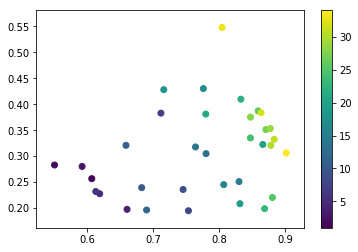

In [1087]:
plt.scatter(mean_val['Circular'], mean_val['AspectR'], c = unique_labels)
plt.colorbar()

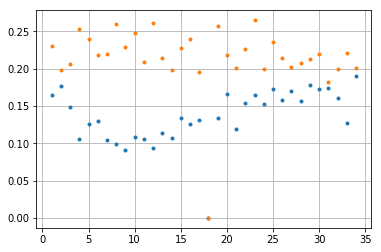

In [1036]:
plt.plot(mean_dissimilarities_['Circular'].loc[17], '.')
plt.plot(mean_dissimilarities_['AspectR'].loc[17], '.')
plt.grid()

In [1066]:
group = np.zeros((len(normalized_parameters.columns), len(mean_dissimilarities)))

for n,c in enumerate(normalized_parameters.columns):

    group[n,:] = mean_dissimilarities_[c].loc[20]

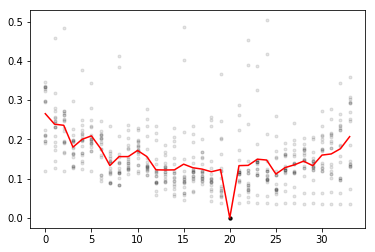

In [1067]:
for n,c in enumerate(normalized_parameters.columns):
    
    plt.plot(group[n,:], 'k.', alpha = 0.1)

plt.plot(np.mean(group, axis =0), 'r-')
# plt.plot(mean_bc_distance[:,13] / 5., 'b--')

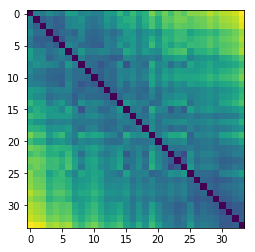

In [1068]:
plt.imshow(mean_bc_distance)

In [1127]:
from sklearn.feature_selection import f_regression, mutual_info_classif, chi2

np.random.seed(0)
X = normalized_parameters.values
y = final_classes_df['34']

mi = mutual_info_classif(X, y)
mi /= np.max(mi)

indices = np.argsort(mi)[::-1]

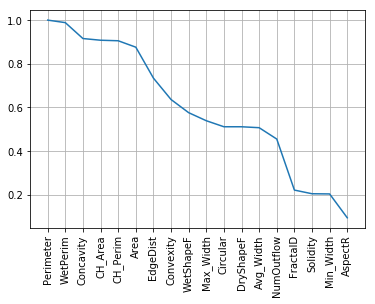

In [1128]:
plt.plot(mi[indices])
plt.xticks(range(X.shape[1]), scaled_parameters.columns[indices], rotation = 90)
plt.xlim([-1, X.shape[1]])
plt.grid()

In [1142]:
sum(scaled_parameters['Circular'] > 0.8) / float(len(islands)) * 100

48.3454398708636

In [1141]:
sum(scaled_parameters['Circular'] > 0.8)
labels = final_classes_df['34']

for l in unique_labels:
    
    loc = np.where(labels == l)[0]
    
    print(sum(scaled_parameters.loc[loc,'Circular'] > 0.8) / float(len(loc)) * 100)
    

6.81818181818
0.0
0.0
0.0
0.0
0.0
20.0
25.4545454545
14.6341463415
8.57142857143
0.0
0.0
38.4615384615
30.4347826087
68.9655172414
60.5263157895
58.064516129
16.0
67.3469387755
84.0
42.8571428571
70.1754385965
86.0
80.6451612903
97.6744186047
73.3333333333
81.0810810811
73.6842105263
88.0
84.6153846154
93.75
86.6666666667
61.1111111111
100.0


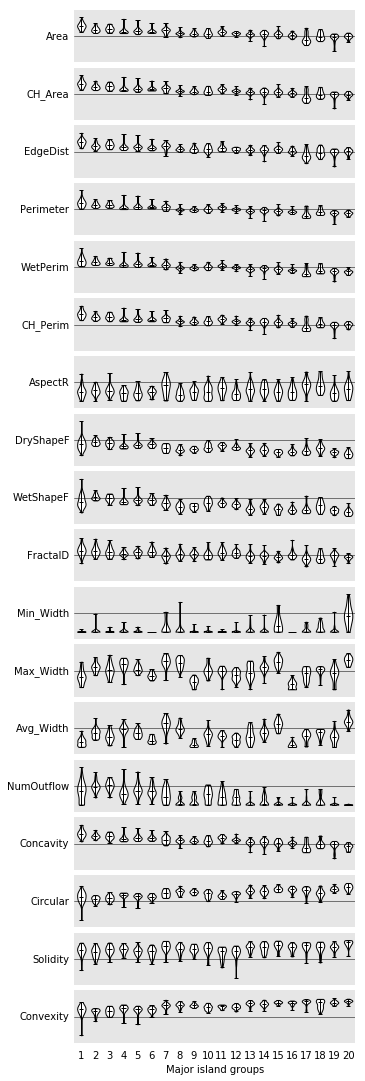

In [1157]:
import matplotlib.gridspec as gridspec

'''
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

The final classification scheme uses
threshold = 0.8
distance = 0.3

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
'''

cmap = plt.cm.gray
norm = mpl.colors.Normalize(vmin=-0.8, vmax=0.1)

r = 0.3
# cols = [i for i in data.columns if i != 'class']

data = scaled_parameters.copy()
data['class'] = final_classes_df['34']
ioi_classes =  range(1,21)
cols = scaled_parameters.columns
cols_clean = cols
# islands_of_interest = [252, 624, 694, 808, 1027, 1005, 1000, 1053, 210, 193]

# ioi_classes_all = [data.loc[i,'class'] for i in islands_of_interest]
# ioi_classes = np.unique(ioi_classes_all)


# ioi_classes = [0,3,6,4,7,1,2,16,9]
# fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(6, 19))

vals_all = []


plt.figure(figsize = (6, 19))
gs1 = gridspec.GridSpec(len(cols),1)
gs1.update(wspace=0.075, hspace=0.1, left=0.3, right=0.95) # set the spacing between axes. 

axes = [plt.subplot(gs1[i]) for i in range(len(cols))]

for nn,col in enumerate(cols):

    axes[nn].set_facecolor('0.9')

    vals = [list(data.loc[data['class'] == i, col]- 0.5) for i in ioi_classes]
    vals_med = [np.median(i) for i in vals]

    vals_all.append(vals_med)

    parts = axes[nn].violinplot(vals, range(len(ioi_classes)), points=20, widths=0.6,
                          showmeans=False, showextrema=True, showmedians=True,);

    for n,pc in enumerate(parts['bodies']):
        pc.set_facecolor('w')#cmap(norm(vals_med[n])))
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1)

    for c in parts.keys():
        if c != 'bodies':
            vp = parts[c]
            vp.set_edgecolor('black')
            vp.set_linewidth(1)

    axes[nn].axhline(0, color='black', lw = 0.5)
#     axes[nn].plot(line_range, np.ones_like(line_range) * 0.5, 'k--', lw = 1, zorder = 1)
    axes[nn].set_ylim(-0.7,0.7)
    axes[nn].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    axes[nn].set_xticks(np.unique(data['class']))
#     axes[nn].grid(color='0.5', linestyle='--', linewidth=1)
#     axes[nn].axis(False);
    axes[nn].spines['top'].set_visible(False)
    axes[nn].spines['right'].set_visible(False)
    axes[nn].spines['bottom'].set_visible(False)
    axes[nn].spines['left'].set_visible(False)

    h = axes[nn].set_ylabel(cols_clean[nn], labelpad = 5, horizontalalignment = 'right', verticalalignment = 'center')
    h.set_rotation(0)
    axes[nn].set_xlim(-0.5,len(ioi_classes) - 0.5);#data['class'].max() + 0.5)

axes[nn].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
axes[nn].set_xticks(np.arange(len(ioi_classes)))
axes[nn].set_xticklabels(ioi_classes);
axes[nn].set_xlabel('Major island groups')


fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.95)

# plt.savefig('_figs/violin_major_groups.png')
plt.show()

In [1154]:
vals

[[],
 [0.41964120972939056,
  0.35216112200625926,
  0.4082362796845288,
  0.3223673775688921,
  0.4188503367784615,
  0.23920733836715324,
  0.35912468856155655,
  0.1529981464108956,
  0.40178930254235456,
  0.2639566251377441,
  0.24891667728574074,
  0.5,
  0.35651242646814774,
  0.1475747778566333,
  0.3440607295419844,
  0.255221483770007,
  0.2923357104318025,
  0.29820057016859713,
  0.3175836383363414,
  0.28868029280857743,
  0.3981849242849471,
  0.22279618081194075,
  0.19361422917279947,
  0.24636006881111594,
  0.3205584042078683,
  0.30371285938189196,
  0.30447752824305596,
  0.20015567973760084,
  0.311523612624766,
  0.2408631337243693,
  0.3277913728811612,
  0.2131708000343826,
  0.2683884697112672,
  0.2460671452613219,
  0.2802227328503194,
  0.1547170991065946,
  0.24448218867544702,
  0.27932152910371366,
  0.1544703156326258,
  0.22675578793848905,
  0.1959862664539631,
  0.13402147827642652,
  0.1247676247929741,
  0.16295697925742159],
 [0.34643147648100525,


Feature ranking:
1. feature 11 (0.079548)
2. feature 12 (0.079094)
3. feature 14 (0.064604)
4. feature 1 (0.063315)
5. feature 4 (0.062415)
6. feature 5 (0.062211)
7. feature 3 (0.060415)
8. feature 0 (0.055808)
9. feature 7 (0.055330)
10. feature 2 (0.052565)
11. feature 15 (0.052140)
12. feature 8 (0.050318)
13. feature 17 (0.048915)
14. feature 16 (0.047876)
15. feature 6 (0.047698)
16. feature 9 (0.046510)
17. feature 10 (0.035788)
18. feature 13 (0.035449)


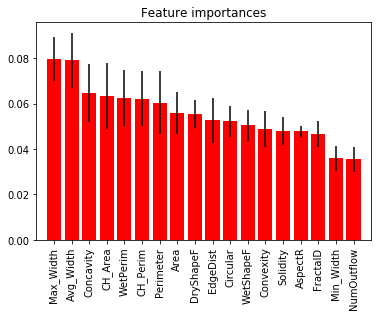

In [1117]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier


X = scaled_parameters.values
y = final_classes_df['34']

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=10,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), normalized_parameters.columns[indices], rotation = 90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [903]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_classif, chi2

np.random.seed(0)
X = scaled_parameters.values
y = labels

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_classif(X, y)
mi /= np.max(mi)


(-1, 20)

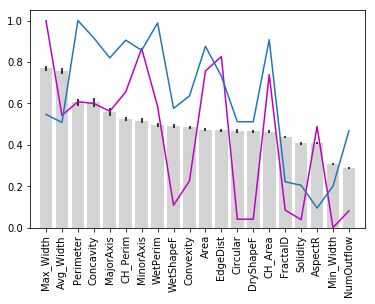

In [905]:


plt.bar(range(X.shape[1]), importances[indices] * 10,
       color="lightgray", yerr=std[indices], align="center")

plt.plot(range(X.shape[1]), f_test[indices], 'm')
plt.plot(range(X.shape[1]), mi[indices])
plt.xticks(range(X.shape[1]), scaled_parameters.columns[indices], rotation = 90)
plt.xlim([-1, X.shape[1]])

In [1126]:
pca_results

,Explained Variance,Area,CH_Area,EdgeDist,Perimeter,WetPerim,CH_Perim,AspectR,MajorAxis,MinorAxis,...,WetShapeF,FractalD,Min_Width,Max_Width,Avg_Width,NumOutflow,Concavity,Circular,Solidity,Convexity
Dimension 1,0.6040,0.2920,0.2995,0.2781,0.2658,0.2752,0.2936,-0.0619,0.2820,0.2971,...,0.2239,0.1007,-0.0583,0.1181,0.0436,0.2489,0.3168,-0.1729,-0.1149,-0.1698
Dimension 2,0.1798,-0.0032,-0.0116,-0.0074,-0.0114,-0.0093,0.0010,0.1218,0.0119,-0.0309,...,-0.0210,-0.0986,0.2754,0.6914,0.6354,-0.0385,-0.0489,0.0310,0.0898,0.0441
Dimension 3,0.0826,-0.1382,-0.1092,-0.2353,-0.0186,-0.0067,-0.0533,0.6625,0.0063,-0.2183,...,0.2940,-0.0304,-0.0514,-0.0097,-0.0175,0.1835,-0.0138,-0.3250,-0.2845,-0.0893
Dimension 4,0.0469,-0.1545,-0.1582,-0.1055,-0.0899,-0.0283,-0.1996,-0.5184,-0.2449,-0.0628,...,0.2615,0.1960,-0.1025,0.1612,0.0462,0.5444,-0.1547,-0.1046,0.0404,-0.2639
Dimension 5,0.0320,-0.0653,-0.0183,-0.1000,-0.0356,-0.0734,-0.0265,-0.1980,-0.0520,0.0179,...,-0.0777,0.3605,-0.4262,0.2726,0.0424,-0.4475,0.1352,-0.0681,-0.5574,0.0584
Dimension 6,0.0236,-0.0347,-0.0045,-0.0599,0.0003,-0.0160,-0.0160,-0.1650,-0.0304,0.0229,...,0.0085,0.3107,0.8119,-0.2437,0.0514,-0.1086,0.0553,-0.0966,-0.3362,-0.0402
Dimension 7,0.0153,0.0414,0.0122,0.0452,-0.0001,-0.0083,0.0295,0.3216,0.0612,-0.0468,...,-0.1253,0.8386,-0.0413,0.0424,-0.0272,0.1359,-0.0817,0.1078,0.3283,0.0814
Dimension 8,0.0084,0.0110,-0.0357,0.0030,0.0752,0.0886,-0.0314,-0.0656,-0.0393,-0.0114,...,0.2721,0.0757,-0.0210,-0.0625,0.0529,-0.5926,-0.1195,-0.2631,0.4806,-0.3974


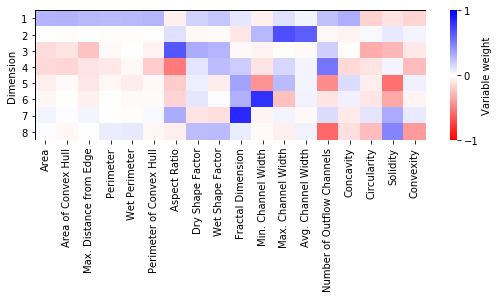

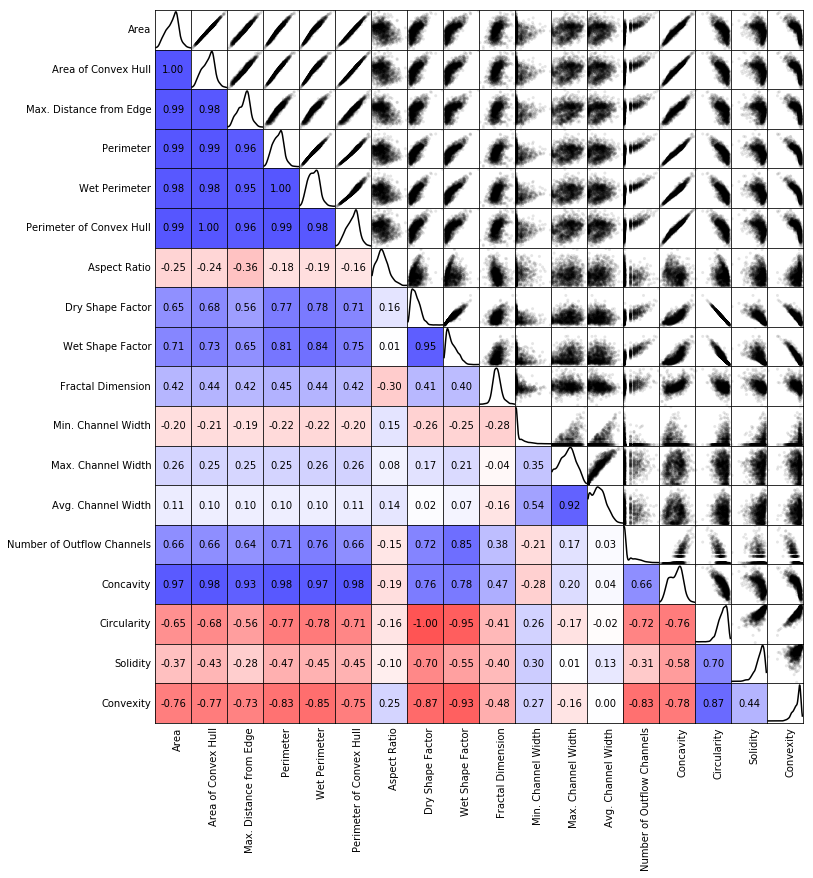

In [1107]:
parameter_labels = ['Area','Area of Convex Hull','Max. Distance from Edge',
                    'Perimeter','Wet Perimeter','Perimeter of Convex Hull',
                    'Aspect Ratio',#'Major Axis','Minor Axis',
                    'Dry Shape Factor','Wet Shape Factor','Fractal Dimension',
                    'Min. Channel Width','Max. Channel Width','Avg. Channel Width','Number of Outflow Channels',
                    'Concavity','Circularity','Solidity','Convexity',]
#                     'Perimeter Equivalent Diameter','Equivalent Area Diameter']

plt.figure(figsize=(7,4))

pca_corr = pca_results[scaled_parameters.columns.values]

pd.to_pickle(pca_corr, '_PCA/pca_correlations.p')

ax = sns.heatmap(pca_corr,
            vmin=-1, vmax = 1,
            cmap = 'bwr_r',
            cbar_kws={'label': 'Variable weight', 'ticks': [-1,0,1]},
            xticklabels = parameter_labels)
ax.set_yticklabels(range(1,11),rotation = 0);
ax.set_ylabel('Dimension')

ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=pca_corr.shape[0], color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=pca_corr.shape[1], color='k',linewidth=1)


plt.subplots_adjust(left = 0.08, right = 1.05, top = 0.95, bottom = 0.5)

plt.savefig(output_dir + 'pca__variable_weight.png', dpi = 300, )    

plt.figure(figsize=(5, 3))

plt.grid(zorder=1, alpha = 0.25)

plt.bar(range(len(explained_variance)),explained_variance*100, zorder=2)
plt.plot(range(len(explained_variance)),explained_variance*100, 'ko-', zorder=3)

plt.xlabel('Dimension')
plt.ylabel('Percentage of explained variances')
plt.ylim(0,np.ceil(np.max(explained_variance*10))*10)
plt.xticks(range(0,len(explained_variance)), range(1,len(explained_variance) + 1))

labels = ['{:.1%}'.format(i) for i in explained_variance]
labels = [i if i[0]<>'0' else i[1:] for i in labels]


for label, x, y in zip(labels, range(len(explained_variance)), explained_variance*100):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2,8),
        textcoords='offset points', ha='left', va='center', size=10)
    
plt.savefig(output_dir + 'pca__scree_plot.png', dpi = 300)    
plt.close()

mpl.rcParams.update(inline_rc)

norm = matplotlib.colors.Normalize(vmin = -1.5, vmax = 1.5)
cmap = matplotlib.cm.get_cmap('bwr_r')


axes = pd.plotting.scatter_matrix(scaled_parameters,
                                  alpha = 0.1, figsize = (12,12),
                                  diagonal = 'kde', c = 'k',
                                  density_kwds={'color': 'k'});

corr = scaled_parameters.corr().values


for i,j in zip(*plt.np.triu_indices_from(axes, k=1)):
    
    axes[j,i].clear()
    axes[j,i].set_ylabel(parameter_labels[j], rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')
    axes[j,i].set_xticks([])
    axes[j,i].set_yticks([])
    axes[j,i].set_facecolor(cmap(norm(corr[j,i])))
    axes[j,i].annotate("%.2f" %corr[j,i], (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')

axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[-1,-1].set_xticks([])
axes[-1,-1].set_yticks([])


j = -1
for i in range(len(parameter_labels)):
    axes[j,i].set_xlabel(parameter_labels[i], rotation = 90, horizontalalignment = 'left', verticalalignment = 'top')

    
i,j = 0,0
axes[j,i].set_ylabel(parameter_labels[j], rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')

i,j = -1,-1
axes[j,i].set_ylabel(parameter_labels[j], rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')

plt.subplots_adjust(right = 0.95, left = 0.2, top = 0.95)

plt.savefig('_figures/pca__variable_correlation_matrix.png', dpi = 150)

(-1.03, 1.03)

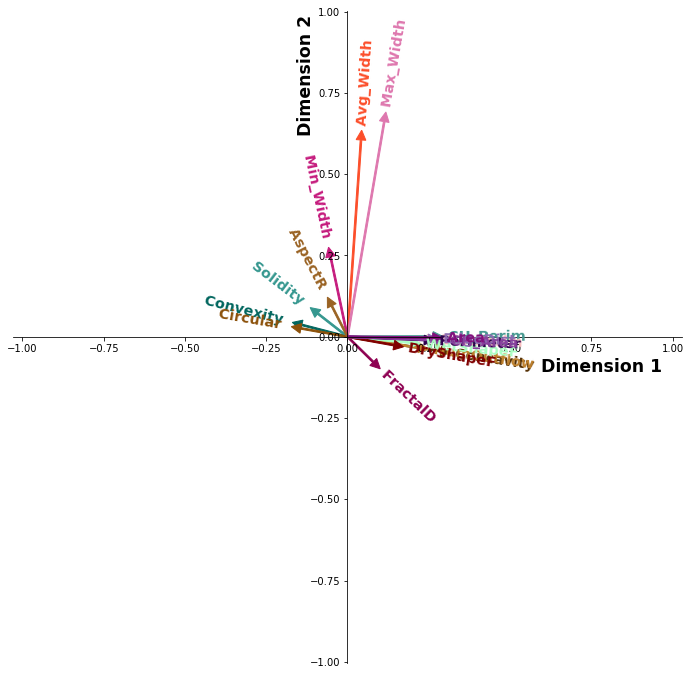

In [1114]:
colors = [
    '#810f7c','#88419d','#8c6bb1',
'#2d004b',
#     '#e6194B', '#3cb44b', '#4363d8', '#f58231', #'#42d4f4',
#           '#f032e6',
          '#fabebe', '#469990', #'#e6beff',
          '#9A6324',  '#800000', '#aaffc3',
          '#8e0152','#c51b7d','#de77ae',
           '#fc4e2a',# num out
          '#bf812d','#543005','#8c510a',
          '#35978f','#01665e','#003c30']
#           '#41ae76', '#2ca25f', '#00441b']

(fig, ax) = plt.subplots(figsize=(12, 12))


# an = np.linspace(0, 2 * np.pi, 100)
# plt.plot(np.cos(an), np.sin(an), '-', c = '0.9')  # Add a unit circle for scale


for i in np.arange(len(pca_corr.columns)-1,-1,-1):
    
    ha = 'left'
    l2 = np.array([pca_corr.iloc[0, i],
             pca_corr.iloc[1, i]])
    
    angle = np.degrees(np.arctan(pca_corr.iloc[1, i] / pca_corr.iloc[0, i]))
    trans_angle = plt.gca().transData.transform_angles(np.array((angle,)),
                                                   l2.reshape((1, 2)))[0]

    
    if np.sign(pca_corr.iloc[0, i]) < 0:
        ha = 'right'
    
#     ax.plot(pca_corr.iloc[0, i],  #0 for PC1
#              pca_corr.iloc[1, i],  #1 for PC2
#             'mx', ms = 10)

#     if cols[i] not in []:#['Island area','Wet shape factor', 'Number of outflow channels', 'Convexity','Solidity', 'Circularity']:

    ax.text(l2[0],l2[1],  #1 for PC2
            ' ' + cols[i] + '  ',
               horizontalalignment=ha, verticalalignment = 'center',
            rotation=trans_angle, rotation_mode='anchor', color = colors[i], fontsize='x-large', weight = 'bold')
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca_corr.iloc[0, i],  #0 for PC1
             pca_corr.iloc[1, i],  #1 for PC2
             head_width=0.03,
             head_length=0.03,
             width = 0.005,
                length_includes_head = True,
            color = colors[i])
    

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.axis('equal');

ax.set_xlabel('Dimension 1', horizontalalignment='center',verticalalignment='top', x=0.88, fontsize = 'xx-large', weight = 'bold')
# ax.xaxis.set_label_coords(0, -0.025)
ax.set_ylabel('Dimension 2', verticalalignment='center', y=0.9, fontsize = 'xx-large', weight = 'bold')


ax.set_xlim(-1.03,1.03)
ax.set_ylim(-1.03,1.03)

# ax.xaxis.set_label_coords(0.8, 0)



In [1113]:
len(pca_corr.columns)

18